# Ensemble Code 2 

### 필요한 모듈을 불러온다

In [1]:
%matplotlib inline  
import numpy as np
import copy
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from collections import OrderedDict
import matplotlib.pyplot as plt
import collections
print("Module Ready!")

Module Ready!


RANDOM_STATE는 실습을 위해 모델의 결과를 같게 하기 위함임

In [2]:
#############################
RANDOM_STATE = 1026
#############################

## 사용할 Personal Loan 데이터셋을 불러옴
> 1. 난수를 고정하여 8:2 = Training data : Test data로 나눔
> 2. Training dataset의 column별 std와 mean을 이용하여 Train/Test dataset standardization 수행

In [3]:
# 사용할 Personal Loan 데이터셋을 불러옵니다.
Rawdata = pd.read_csv('dataset/Personal Loan.csv')
# Print Column names
print("'Personal Loan' data column name : ", list(Rawdata.columns.values))
print("ID와 ZIP Code는 사용하지 않습니다. 또한 Personal Loan을 분류하는 binary classification 문제 입니다.")
# Allocate column index based on Input and Output varaibles
Input_Column_Index = np.concatenate((range(1,4),range(5,9),range(10,14)))
Target_Column_Index = np.array([9])


# 같은 데이터셋을 사용하기 위해서 난수를 고정합니다.
np.random.seed(150)
Train_Index = np.random.choice(np.shape(Rawdata)[0],int(np.shape(Rawdata)[0]*0.8),replace=False)

# Input variable과 Output variable을 Numpy array로 변환합니다.
Rawdata_Input = np.array(Rawdata)[:,Input_Column_Index]
Rawdata_Output = np.array(Rawdata)[:,Target_Column_Index]


# Training data와 Test data를 나누어 줍니다.
Train_Input = Rawdata_Input[Train_Index,:]
Train_Output = Rawdata_Output[Train_Index,:]
Test_Input = Rawdata_Input[np.delete(range(np.shape(Rawdata)[0]),Train_Index),:]
Test_Output = Rawdata_Output[np.delete(range(np.shape(Rawdata)[0]),Train_Index),:]
print('Data partition complete! \nTrain_Input shape :',np.shape(Train_Input),'\nTrain_Output shape :',np.shape(Train_Output))
print('Test_Input shape :',np.shape(Test_Input),'\nTest_Output shape :',np.shape(Test_Output))

# Input variable MinMax Normalization based on Training data

def standardization(Data,Data2):
    return ((Data - np.mean(Data2, axis=0)) / np.std(Data2, axis=0))

Train_Input_Normalized = copy.deepcopy(standardization(Train_Input,Train_Input))
Test_Input_Normalized = copy.deepcopy(standardization(Test_Input,Train_Input))
print("standardization complete!")

'Personal Loan' data column name :  ['ID', 'Age', 'Experience', 'Income', 'ZIP Code', 'Family', 'CCAvg', 'Education', 'Mortgage', 'Personal Loan', 'Securities Account', 'CD Account', 'Online', 'CreditCard']
ID와 ZIP Code는 사용하지 않습니다. 또한 Personal Loan을 분류하는 binary classification 문제 입니다.
Data partition complete! 
Train_Input shape : (2000, 11) 
Train_Output shape : (2000, 1)
Test_Input shape : (500, 11) 
Test_Output shape : (500, 1)
standardization complete!


In [4]:
# 평가지표를 위한 함수를 생성한다.
def Valid_Index(Data,NAME):
    Accuracy = (Data[0,0]+Data[1,1])/np.sum(Data)
    TPR = Data[1,1]/np.sum(Data[1,:])
    TNR = Data[0,0]/np.sum(Data[0,:])
    Precision = Data[1,1]/np.sum(Data[:,1])
    BCR = np.sqrt(TPR*TNR)
    F1 = (2*TPR*Precision)/(TPR+Precision)
    TMP=pd.DataFrame({'Model' : NAME,
                  'Accuracy' : [Accuracy],
                  'TPR': [TPR],
                  'TNR': [TNR],
                  'Precision': [Precision],
                  'BCR': [BCR],
                  'F1': [F1]})
    Results=TMP[['Model','Accuracy','F1','BCR','Precision','TPR','TNR']]
    return(Results)



# Model1. Neural network

In [5]:
###############################################
# Neural Network Hyperparameter Set
###############################################
ACTIVATION = 'tanh'        
SOLVER = 'adam'            
BATCH_SIZE = 32            
HIDDEN_LAYER= [10,10,10]   
TR_INPUT = Train_Input     
TR_OUTPUT = Train_Output[:,0]
Iterlation = 3000
L2_Penalty = 0.001
Visualization = False 
Validation_Percent = 0.0 
Decay_Method = 'invscaling'
Power_Value = 0.5          
Tolerence_Value = 1e-04 
###############################################

def NeuralNetwork(HIDDEN_LAYER,Train_Input,TR_OUTPUT,Val_Input,Val_Output):
    MLP=MLPClassifier(activation=ACTIVATION,solver=SOLVER,alpha=L2_Penalty,
                      hidden_layer_sizes=HIDDEN_LAYER,
                      batch_size=BATCH_SIZE,max_iter=Iterlation,verbose=Visualization,early_stopping=False,power_t=Power_Value,
                      validation_fraction=Validation_Percent,learning_rate=Decay_Method,tol=Tolerence_Value,
                      random_state =RANDOM_STATE).fit(Train_Input,TR_OUTPUT[:,0])
    Predict_Value = MLP.predict(Val_Input)
    return(np.concatenate((Predict_Value[:,np.newaxis],Val_Output),axis=1))

Model1=NeuralNetwork(HIDDEN_LAYER=[20],Train_Input=Train_Input_Normalized,
              TR_OUTPUT=Train_Output,Val_Input=Test_Input_Normalized,Val_Output=Test_Output)

In [6]:
Model1_Results=Valid_Index(confusion_matrix(Model1[:,1],Model1[:,0]),"Neuralnetwork")
Model1_Results

,Model,Accuracy,F1,BCR,Precision,TPR,TNR
0,Neuralnetwork,0.982,0.917431,0.941714,0.943396,0.892857,0.993243


# Model2. RandomForest

In [7]:
def RandomForest(NUMBER,Train_Input,TR_OUTPUT,Val_Input,Val_Output):
    RF=RandomForestClassifier(n_estimators=NUMBER,
                           max_features="sqrt",
                           random_state=RANDOM_STATE).fit(Train_Input,TR_OUTPUT[:,0])

    Predict_Value = RF.predict(Val_Input)
    return(np.concatenate((Predict_Value[:,np.newaxis],Val_Output),axis=1))


Model2=RandomForest(NUMBER=150,Train_Input=Train_Input_Normalized,
              TR_OUTPUT=Train_Output,Val_Input=Test_Input_Normalized,Val_Output=Test_Output)


In [8]:
Model2_Results=Valid_Index(confusion_matrix(Model2[:,1],Model2[:,0]),"RandomForset")
Model2_Results

,Model,Accuracy,F1,BCR,Precision,TPR,TNR
0,RandomForset,0.984,0.927273,0.951084,0.944444,0.910714,0.993243


# Model3. Adaboost

In [9]:
def AdaBoost(NUMBER,Train_Input,TR_OUTPUT,Val_Input,Val_Output):
    ADA=AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),n_estimators=NUMBER,algorithm="SAMME",
                           random_state=RANDOM_STATE).fit(Train_Input,TR_OUTPUT[:,0])
    Predict_Value = ADA.predict(Val_Input)
    return(np.concatenate((Predict_Value[:,np.newaxis],Val_Output),axis=1))


Model3=AdaBoost(NUMBER=300,Train_Input=Train_Input_Normalized,
              TR_OUTPUT=Train_Output,Val_Input=Test_Input_Normalized,Val_Output=Test_Output)

In [10]:
Model3_Results=Valid_Index(confusion_matrix(Model3[:,1],Model3[:,0]),"Adaboost")
Model3_Results

,Model,Accuracy,F1,BCR,Precision,TPR,TNR
0,Adaboost,0.978,0.895238,0.91406,0.959184,0.839286,0.995495


# Model4. Bagging ANN

In [11]:
def B_NeuralNetwork(HIDDEN_LAYER,Train_Input,TR_OUTPUT,Val_Input,Val_Output):
    MLP=MLPClassifier(activation=ACTIVATION,solver=SOLVER,alpha=L2_Penalty,
                      hidden_layer_sizes=HIDDEN_LAYER,max_iter=3000,
                      batch_size=BATCH_SIZE,verbose=Visualization,early_stopping=False,power_t=Power_Value,
                      validation_fraction=Validation_Percent,learning_rate=Decay_Method,tol=Tolerence_Value,random_state =RANDOM_STATE)
    BMLP = BaggingClassifier(n_estimators=30, base_estimator=MLP, random_state=RANDOM_STATE, n_jobs=-1).fit(Train_Input, TR_OUTPUT[:, 0])
    Predict_Value = BMLP.predict(Val_Input)
    return(np.concatenate((Predict_Value[:,np.newaxis],Val_Output),axis=1))


Model4=B_NeuralNetwork(HIDDEN_LAYER=[20,20],Train_Input=Train_Input_Normalized,
              TR_OUTPUT=Train_Output,Val_Input=Test_Input_Normalized,Val_Output=Test_Output)

In [12]:
Model4_Results=Valid_Index(confusion_matrix(Model4[:,1],Model4[:,0]),"B_Neuralnetwork")
Model4_Results

,Model,Accuracy,F1,BCR,Precision,TPR,TNR
0,B_Neuralnetwork,0.978,0.900901,0.939576,0.909091,0.892857,0.988739


# Model5. Bagging Decision Tree

In [13]:
def B_Tree(NUMBER,Train_Input,TR_OUTPUT,Val_Input,Val_Output):
    Tree = DecisionTreeClassifier(max_depth=NUMBER, random_state=RANDOM_STATE).fit(Train_Input, TR_OUTPUT[:, 0])
    BMLP = BaggingClassifier(n_estimators=30, base_estimator=Tree, random_state=RANDOM_STATE, n_jobs=-1).fit(Train_Input, TR_OUTPUT[:, 0])
    Predict_Value = BMLP.predict(Val_Input)
    return(np.concatenate((Predict_Value[:,np.newaxis],Val_Output),axis=1))


Model5=B_Tree(NUMBER=6,Train_Input=Train_Input_Normalized,
              TR_OUTPUT=Train_Output,Val_Input=Test_Input_Normalized,Val_Output=Test_Output)

In [14]:
Model5_Results=Valid_Index(confusion_matrix(Model5[:,1],Model5[:,0]),"B_Tree")
Model5_Results

,Model,Accuracy,F1,BCR,Precision,TPR,TNR
0,B_Tree,0.982,0.920354,0.958183,0.912281,0.928571,0.988739


# Model6. Gradient Boosting Machine

In [15]:
def GBM(NUMBER,Train_Input,TR_OUTPUT,Val_Input,Val_Output):
    gbm=GradientBoostingClassifier(n_estimators=NUMBER,random_state=RANDOM_STATE).fit(Train_Input,TR_OUTPUT[:,0])
    Predict_Value = gbm.predict(Val_Input)
    return(np.concatenate((Predict_Value[:,np.newaxis],Val_Output),axis=1))

Model6=GBM(NUMBER=50,Train_Input=Train_Input_Normalized,
              TR_OUTPUT=Train_Output,Val_Input=Test_Input_Normalized,Val_Output=Test_Output)

In [16]:
Model6_Results=Valid_Index(confusion_matrix(Model6[:,1],Model6[:,0]),"GBM")
Model6_Results

,Model,Accuracy,F1,BCR,Precision,TPR,TNR
0,GBM,0.984,0.928571,0.959274,0.928571,0.928571,0.990991


In [17]:
Results=pd.concat((Model1_Results,Model2_Results,Model3_Results,
          Model4_Results,Model5_Results,Model6_Results),axis=0)
Results = Results.sort_values(by=['F1'],ascending=False)
Results

,Model,Accuracy,F1,BCR,Precision,TPR,TNR
0,GBM,0.984,0.928571,0.959274,0.928571,0.928571,0.990991
0,RandomForset,0.984,0.927273,0.951084,0.944444,0.910714,0.993243
0,B_Tree,0.982,0.920354,0.958183,0.912281,0.928571,0.988739
0,Neuralnetwork,0.982,0.917431,0.941714,0.943396,0.892857,0.993243
0,B_Neuralnetwork,0.978,0.900901,0.939576,0.909091,0.892857,0.988739
0,Adaboost,0.978,0.895238,0.914060,0.959184,0.839286,0.995495


# Feature Importance

In [18]:
Use_Feature_Name=list(np.array(list(Rawdata.columns.values))[np.concatenate((range(1,4),range(5,9),range(10,14)))])
OP_RF=RandomForestClassifier(n_estimators=150,max_features="sqrt",
                           random_state=RANDOM_STATE).fit(Train_Input_Normalized,Train_Output[:,0])
OP_GBM=GradientBoostingClassifier(n_estimators=50,
                           random_state=RANDOM_STATE).fit(Train_Input_Normalized,Train_Output[:,0])

def plot_feature_importances(model):
    n_features = np.shape(Train_Input_Normalized)[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), Use_Feature_Name)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)
    plt.rcParams.update({'font.size': 8})

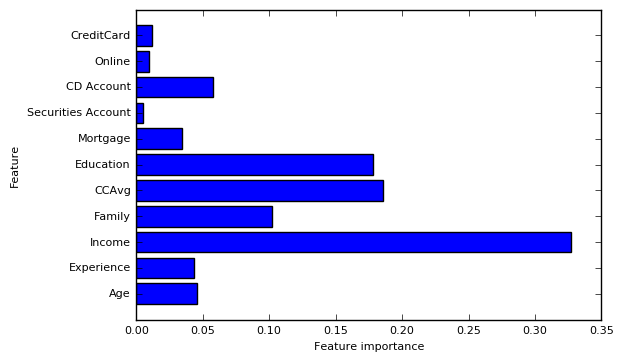

In [19]:
plot_feature_importances(OP_RF)

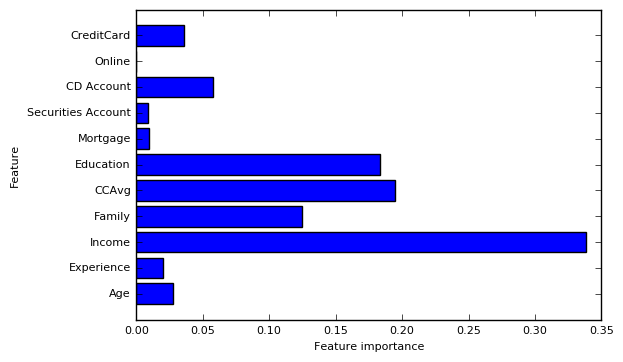

In [20]:
plot_feature_importances(OP_GBM)